# Unsupervised Clustering - Student Segmentation

## Objective
Segment students into distinct learning personas using K-Means clustering based on behavioural features.

## CRISP-DM Stage
Modelling and Evaluation

## Methods
- Feature selection and standardisation
- Elbow Method for optimal k determination
- Silhouette Score analysis
- K-Means clustering
- PCA visualisation
- Cluster profiling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('All libraries imported successfully')
print('=' * 80)

All libraries imported successfully


## Section 1: Load and Prepare Clustering Features

Create 4 simple, interpretable features for student segmentation.

In [8]:
print('\n' + '=' * 80)
print('CLUSTERING: FEATURE PREPARATION')
print('=' * 80)

df_encoded = pd.read_pickle('../2_Outputs/df_encoded_full.pkl')

# Create 4 simple, interpretable features
print('Creating explainable student engagement features...\n')

df_features = df_encoded.copy()

# Feature 1: Engagement Level (how active is the student?)
df_features['engagement'] = (
    df_encoded['total_clicks'] / df_encoded['total_clicks'].quantile(0.95)
).clip(0, 1)  # Normalise to 0-1, cap at top 5%

# Feature 2: Consistency (do they engage steadily or sporadically?)
df_features['consistency'] = (
    df_encoded['days_active'] / df_encoded['days_active'].max()
)  # Proportion of course days active

# Feature 3: On-Time Performance (do they submit work on time?)
df_features['timeliness'] = 1 - (
    df_encoded['num_late_submissions'] / (df_encoded['num_assessments'] + 1)
).clip(0, 1)  # 1 = all on time, 0 = all late

# Feature 4: Academic Performance (how well do they score?)
df_features['performance'] = (
    df_encoded['target_score'] / 100
).clip(0, 1)  # Normalise score to 0-1

# Select only the 4 engineered features
clustering_features = ['engagement', 'consistency', 'timeliness', 'performance']

print(f'Clustering Features ({len(clustering_features)}):')
for feat in clustering_features:
    print(f'  • {feat.capitalize()}: Min={df_features[feat].min():.3f}, Max={df_features[feat].max():.3f}, Mean={df_features[feat].mean():.3f}')

X_clustering = df_features[clustering_features].fillna(0)

print(f'\nClustering dataset shape: {X_clustering.shape}')
print(f'\nFeature Summary:')
print(X_clustering.describe())

scaler = StandardScaler()
X_clustering_scaled = scaler.fit_transform(X_clustering)

print(f'\nScaled features shape: {X_clustering_scaled.shape}')
print('Ready for clustering...')


CLUSTERING: FEATURE PREPARATION
Creating explainable student engagement features...

Clustering Features (4):
  • Engagement: Min=0.000, Max=1.000, Mean=0.243
  • Consistency: Min=0.000, Max=1.000, Mean=0.106
  • Timeliness: Min=0.077, Max=1.000, Mean=0.810
  • Performance: Min=0.000, Max=1.000, Mean=0.431

Clustering dataset shape: (32593, 4)

Feature Summary:
         engagement   consistency    timeliness   performance
count  32593.000000  32593.000000  32593.000000  32593.000000
mean       0.243379      0.106212      0.810473      0.430828
std        0.283014      0.121854      0.239119      0.389018
min        0.000000      0.000000      0.076923      0.000000
25%        0.031086      0.017544      0.600000      0.000000
50%        0.131786      0.065302      1.000000      0.407000
75%        0.346979      0.151722      1.000000      0.807500
max        1.000000      1.000000      1.000000      1.000000

Scaled features shape: (32593, 4)
Ready for clustering...


## Section 2: Determine Optimal Clusters - Elbow Method

Identify optimal number of clusters by analysing within-cluster sum of squares.


ELBOW METHOD FOR OPTIMAL K
k=2: Inertia = 150376.6875
k=3: Inertia = 118374.1406
k=4: Inertia = 102470.6250
k=5: Inertia = 91052.0859
k=6: Inertia = 84375.5781
k=7: Inertia = 77945.7812
k=8: Inertia = 72239.5156
k=9: Inertia = 67948.2500
k=10: Inertia = 64845.1953


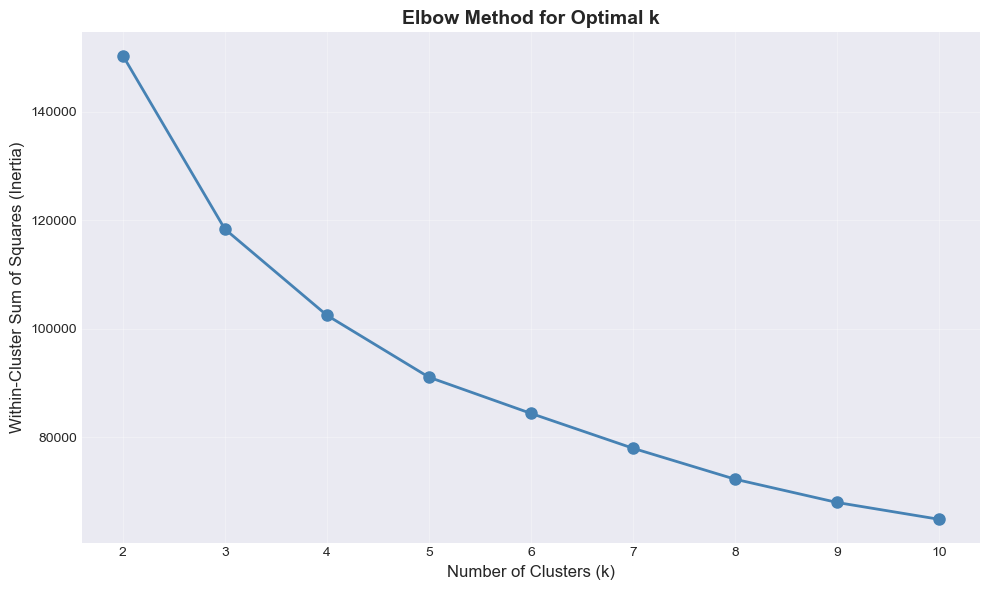

In [3]:
print('\n' + '=' * 80)
print('ELBOW METHOD FOR OPTIMAL K')
print('=' * 80)

inertias = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_clustering_scaled)
    inertias.append(kmeans.inertia_)
    print(f'k={k}: Inertia = {kmeans.inertia_:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, marker='o', linestyle='-', linewidth=2, markersize=8, color='steelblue')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (Inertia)', fontsize=12)
plt.title('Elbow Method for Optimal k', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)
plt.tight_layout()
plt.show()

## Section 3: Determine Optimal Clusters - Silhouette Score

Evaluate cluster quality using Silhouette Score analysis.


SILHOUETTE SCORE FOR OPTIMAL K
k=2: Silhouette Score = 0.4257
k=3: Silhouette Score = 0.4648
k=4: Silhouette Score = 0.4808
k=5: Silhouette Score = 0.4940
k=6: Silhouette Score = 0.4784
k=7: Silhouette Score = 0.4844
k=8: Silhouette Score = 0.4506
k=9: Silhouette Score = 0.4417
k=10: Silhouette Score = 0.4386

Optimal k (based on Silhouette Score): 5


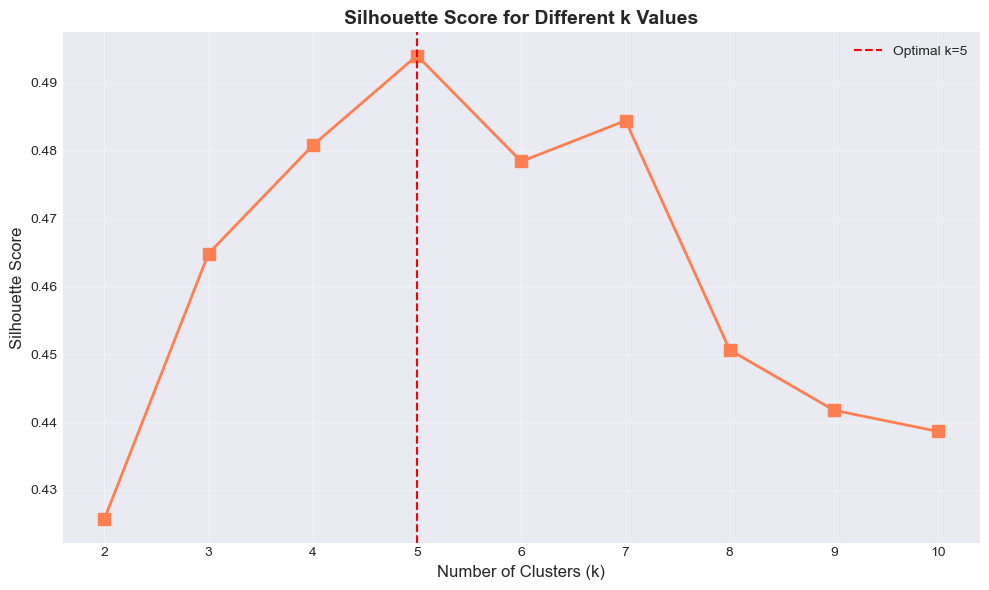


Selected k: 5


In [15]:
print('\n' + '=' * 80)
print('SILHOUETTE SCORE FOR OPTIMAL K')
print('=' * 80)

silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_clustering_scaled)
    silhouette_avg = silhouette_score(X_clustering_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f'k={k}: Silhouette Score = {silhouette_avg:.4f}')

optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
print(f'\nOptimal k (based on Silhouette Score): {optimal_k_silhouette}')

plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='s', linestyle='-', linewidth=2, markersize=8, color='coral')
plt.axvline(x=optimal_k_silhouette, color='red', linestyle='--', label=f'Optimal k={optimal_k_silhouette}')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score for Different k Values', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)
plt.legend()
plt.tight_layout()
plt.show()

optimal_k = 5
print(f'\nSelected k: {optimal_k}')

## Section 4: K-Means Clustering

Implement K-Means with optimal number of clusters.

In [19]:
print('\n' + '=' * 80)
print('K-MEANS CLUSTERING')
print('=' * 80)

optimal_k = 4

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_clustering_scaled)

df_encoded['cluster'] = cluster_labels

print(f'K-Means converged in {kmeans_final.n_iter_} iterations')
print(f'\nCluster Distribution:')
print(df_encoded['cluster'].value_counts().sort_index())

silhouette_avg = silhouette_score(X_clustering_scaled, cluster_labels)
print(f'\nSilhouette Score (final model): {silhouette_avg:.4f}')

sample_silhouette_values = silhouette_samples(X_clustering_scaled, cluster_labels)
print(f'Average sample Silhouette Value: {sample_silhouette_values.mean():.4f}')


K-MEANS CLUSTERING
K-Means converged in 17 iterations

Cluster Distribution:
cluster
0     3979
1    12647
2     7475
3     8492
Name: count, dtype: int64

Silhouette Score (final model): 0.4808
Average sample Silhouette Value: 0.4808


## Section 5: PCA Visualisation

Reduce dimensions to 2D for cluster visualisation.


PCA DIMENSIONALITY REDUCTION
PCA Explained Variance Ratio: [0.61975706 0.2619301 ]
Total Variance Explained: 0.8817


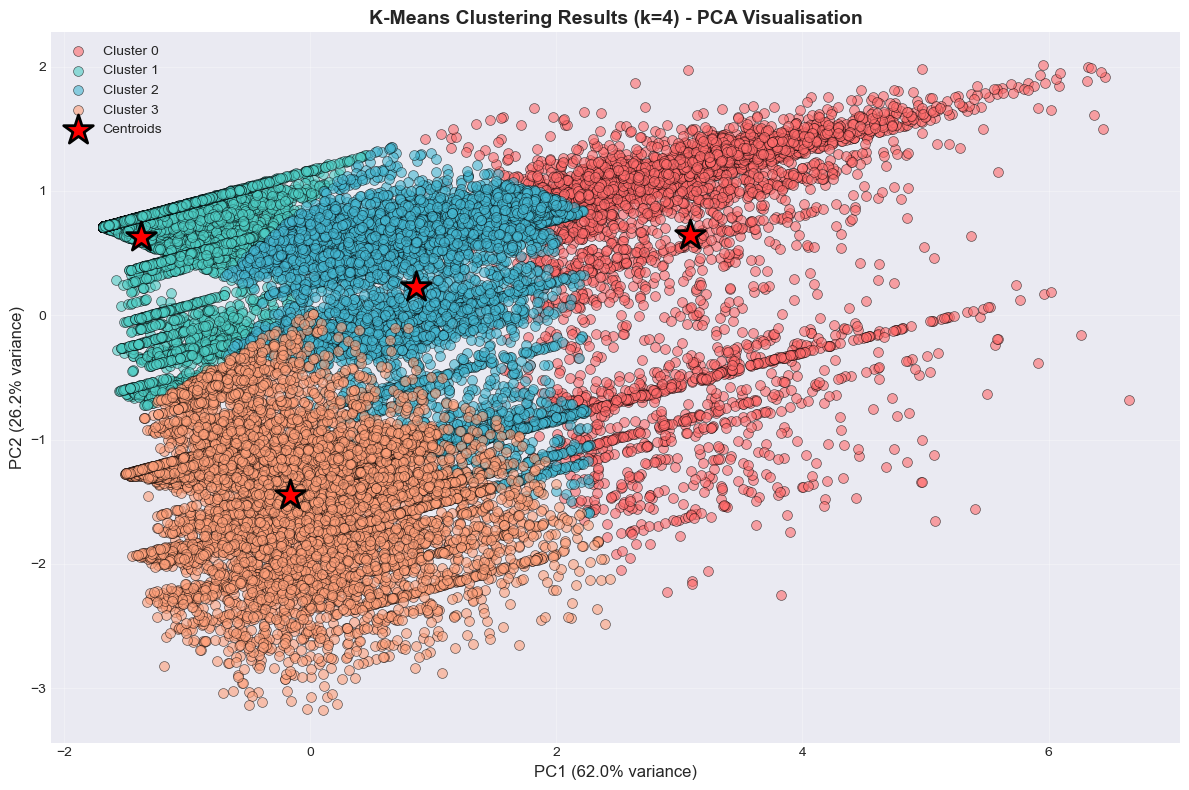

In [20]:
print('\n' + '=' * 80)
print('PCA DIMENSIONALITY REDUCTION')
print('=' * 80)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_clustering_scaled)

print(f'PCA Explained Variance Ratio: {pca.explained_variance_ratio_}')
print(f'Total Variance Explained: {pca.explained_variance_ratio_.sum():.4f}')

pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = cluster_labels

# Transform centroids for visualisation
centroids_pca = pca.transform(kmeans_final.cluster_centers_)

# Create scatter plot
plt.figure(figsize=(12, 8))

colours = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F']
for i in range(optimal_k):
    mask = cluster_labels == i
    plt.scatter(
        X_pca[mask, 0], X_pca[mask, 1],
        c=colours[i % len(colours)],
        label=f'Cluster {i}',
        alpha=0.6,
        s=50,
        edgecolors='black',
        linewidth=0.5
    )

plt.scatter(
    centroids_pca[:, 0], centroids_pca[:, 1],
    c='red', marker='*', s=500,
    label='Centroids',
    edgecolors='black',
    linewidth=2
)

colours_for_legend = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F']

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
plt.title(f'K-Means Clustering Results (k={optimal_k}) - PCA Visualisation', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Section 6: Cluster Profiling

Analyse cluster characteristics and create learning personas.


CLUSTER PROFILING AND INTERPRETATION

Cluster Profiles (Mean Feature Values):
         engagement  consistency  timeliness  performance
cluster                                                  
0            0.8651       0.3622      0.8529       0.8212
1            0.0531       0.0245      0.9718       0.0519
2            0.3389       0.1451      0.8924       0.8021
3            0.1514       0.0738      0.4782       0.4855


Detailed Learning Personas:

CLUSTER 0: Highly Engaged | Excellent | Very Punctual
   Population: 3979 students (12.2%)
   ─────────────────────────────────────────
   Engagement Level: Highly Engaged (86.5%)
   Consistency: 36.2% of days active
   Submission Timeliness: Very Punctual (85.3% on-time)
   Academic Performance: Excellent (82.1% normalized score)
   Key Strengths: highly engaged with materials; strong academic performance; excellent time management
   Intervention Needed: inconsistent attendance
   Support Level: MEDIUM PRIORITY (1 risk factor)

CLUSTE

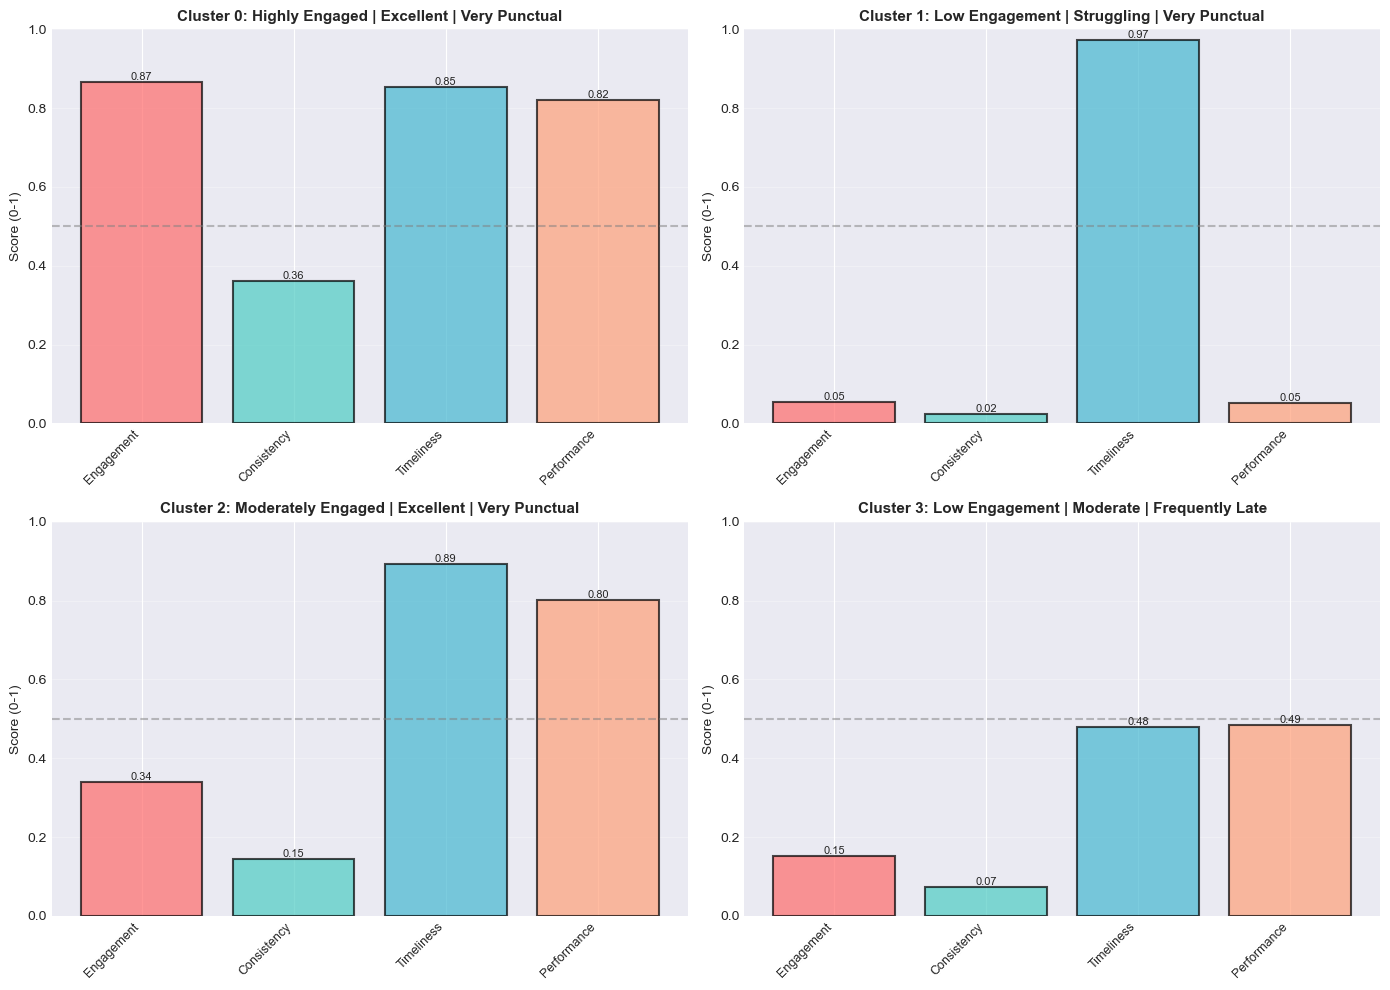

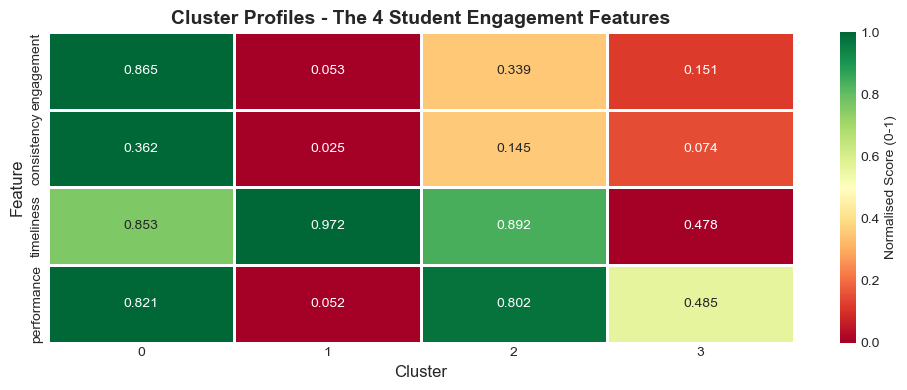


Clustering results saved for final notebook


In [21]:
print('\n' + '=' * 80)
print('CLUSTER PROFILING AND INTERPRETATION')
print('=' * 80)

# Add cluster labels to feature set for profiling
df_features['cluster'] = cluster_labels
cluster_profiles = df_features.groupby('cluster')[clustering_features].mean()

print('\nCluster Profiles (Mean Feature Values):')
print('=' * 80)
print(cluster_profiles.round(4))

# Create comprehensive learning personas
cluster_personas = {}
for cluster_id in range(optimal_k):
    profile = cluster_profiles.loc[cluster_id]
    
    # Direct feature values (already 0-1 normalized)
    engagement = profile['engagement']
    consistency = profile['consistency']
    timeliness = profile['timeliness']
    performance = profile['performance']
    
    # Categorise engagement levels (3-tier)
    if engagement >= 0.67:
        engagement_level = 'Highly Engaged'
    elif engagement >= 0.33:
        engagement_level = 'Moderately Engaged'
    else:
        engagement_level = 'Low Engagement'
    
    # Categorise performance (4-tier)
    if performance >= 0.75:
        performance_level = 'Excellent'
    elif performance >= 0.5:
        performance_level = 'Good'
    elif performance >= 0.25:
        performance_level = 'Moderate'
    else:
        performance_level = 'Struggling'
    
    # Categorise timeliness (0 = all late, 1 = all on-time)
    if timeliness >= 0.8:
        timeliness_label = 'Very Punctual'
    elif timeliness >= 0.6:
        timeliness_label = 'Usually On-Time'
    elif timeliness >= 0.4:
        timeliness_label = 'Frequently Late'
    else:
        timeliness_label = 'Chronically Late'
    
    # Identify risk factors
    risk_factors = []
    if performance < 0.4:
        risk_factors.append('at-risk academically')
    if timeliness < 0.6:
        risk_factors.append('poor deadline management')
    if engagement < 0.4:
        risk_factors.append('low platform engagement')
    if consistency < 0.4:
        risk_factors.append('inconsistent attendance')
    
    # Identify strengths
    strengths = []
    if engagement >= 0.65:
        strengths.append('highly engaged with materials')
    if consistency >= 0.65:
        strengths.append('consistent active participation')
    if performance >= 0.65:
        strengths.append('strong academic performance')
    if timeliness >= 0.8:
        strengths.append('excellent time management')
    
    # Create persona name
    persona_name = f'{engagement_level} | {performance_level} | {timeliness_label}'
    
    cluster_personas[cluster_id] = {
        'name': persona_name,
        'engagement_level': engagement_level,
        'performance_level': performance_level,
        'timeliness': timeliness_label,
        'engagement': engagement,
        'consistency': consistency,
        'timeliness_score': timeliness,
        'performance': performance,
        'risk_factors': risk_factors,
        'strengths': strengths
    }

print('\n\nDetailed Learning Personas:')
print('=' * 80)
for cluster_id, persona in cluster_personas.items():
    count = (cluster_labels == cluster_id).sum()
    pct = count / len(cluster_labels) * 100
    print(f'\nCLUSTER {cluster_id}: {persona["name"]}')
    print(f'   Population: {count} students ({pct:.1f}%)')
    print(f'   ─────────────────────────────────────────')
    print(f'   Engagement Level: {persona["engagement_level"]} ({persona["engagement"]:.1%})')
    print(f'   Consistency: {persona["consistency"]:.1%} of days active')
    print(f'   Submission Timeliness: {persona["timeliness"]} ({persona["timeliness_score"]:.1%} on-time)')
    print(f'   Academic Performance: {persona["performance_level"]} ({persona["performance"]:.1%} normalized score)')
    
    if persona['strengths']:
        print(f'   Key Strengths: {"; ".join(persona["strengths"])}')
    
    if persona['risk_factors']:
        print(f'   Intervention Needed: {"; ".join(persona["risk_factors"])}')
    
    print(f'   Support Level: ', end='')
    if len(persona['risk_factors']) > 2:
        print(f'HIGH PRIORITY ({len(persona["risk_factors"])} risk factors)')
    elif persona['risk_factors']:
        print(f'MEDIUM PRIORITY ({len(persona["risk_factors"])} risk factor)')
    elif persona['performance_level'] in ['Excellent', 'Good']:
        print('MINIMAL (high performer)')
    else:
        print('MEDIUM PRIORITY (moderate support)')

# Create persona comparison bar chart
print('\n' + '=' * 80)
print('PERSONA CHARACTERISTIC COMPARISON')
print('=' * 80)

# Prepare data for comparison (using the 4 engineered features)
comparison_metrics = ['Engagement', 'Consistency', 'Timeliness', 'Performance']

# Create subplots based on number of clusters
if optimal_k == 2:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
elif optimal_k == 3:
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
elif optimal_k == 4:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
elif optimal_k == 5:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
else:
    fig, axes = plt.subplots(3, 2, figsize=(14, 14))
axes = axes.flatten()

for idx, cluster_id in enumerate(range(optimal_k)):
    persona = cluster_personas[cluster_id]
    
    # Use the 4 normalized features
    metrics = [
        persona['engagement'],
        persona['consistency'],
        persona['timeliness_score'],
        persona['performance']
    ]
    
    ax = axes[idx]
    x_pos = np.arange(len(comparison_metrics))
    colours_bars = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
    
    bars = ax.bar(x_pos, metrics, color=colours_bars, alpha=0.7, edgecolor='black', linewidth=1.5)
    
    ax.set_ylabel('Score (0-1)', fontsize=10)
    ax.set_title(f'Cluster {cluster_id}: {persona["name"]}', fontsize=11, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(comparison_metrics, rotation=45, ha='right', fontsize=9)
    ax.set_ylim(0, 1)
    ax.axhline(y=0.5, color='grey', linestyle='--', alpha=0.5, label='Median')
    ax.grid(True, axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, metric in zip(bars, metrics):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{metric:.2f}',
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Visualise cluster profiles with heatmap
cluster_profiles_normalized = (cluster_profiles - cluster_profiles.min()) / (cluster_profiles.max() - cluster_profiles.min())

fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(
    cluster_profiles_normalized.T,
    annot=cluster_profiles.T.round(3),
    fmt='g',
    cmap='RdYlGn',
    cbar_kws={'label': 'Normalised Score (0-1)'},
    ax=ax,
    linewidths=1
)

ax.set_title('Cluster Profiles - The 4 Student Engagement Features', fontsize=14, fontweight='bold')
ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

# Save clustering results
import pickle
pickle.dump(kmeans_final, open('../2_Outputs/kmeans_model.pkl', 'wb'))
pickle.dump(cluster_labels, open('../2_Outputs/cluster_labels.pkl', 'wb'))
df_features['cluster'] = cluster_labels
df_features.to_pickle('../2_Outputs/df_with_clusters.pkl')

print('\nClustering results saved for final notebook')